In [12]:
import numpy as np
import pandas as pd
import torch
from NashAgent_lib import *
from RAT_env import *
from NashRL import *
import matplotlib.pyplot as plt
from collections import Counter


def predict_action(nn,states):
    if len(states.shape) > 2:
        B, A, D = states.shape  # B = batch size (10), A = agents (3), D = 255
        flat_states = states.view(B * A, D)  # Flatten to shape (30, 255)
        # Forward pass through action_net
        action_list = nn.forward(input=flat_states)
        # Reshape back to (10, 3, -1)
        action_list = action_list.view(B, A, -1)
        return action_list
    else:
        action_list = nn.forward(input=states) 

        return action_list

def evaluate_action_network(rat_env, action_network, n_episodes):
    
    action_network.eval()

    reward_buffer = []
    action_buffer = []
    for i in range(n_episodes):
        rat_env.reset()
        for t in range(0, 30):
            current_state, _, _ = rat_env.get_state()
            state = expand_list(current_state, rat_env.n_users)
            actions = torch.argmax(predict_action(action_network, state[:, :rat_env.n_stations]), dim=1)
            _, _, _, reward = rat_env.step(actions.detach())
            
            action_buffer.append(actions)
            reward_buffer.append(reward)
    
    return reward_buffer, action_buffer




def plot_reward(reward_buffer):
    n_runs = len(reward_buffer)
    n_agents = len(reward_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_rewards = np.array([reward_buffer[run][i] for run in range(n_runs)])
        
        ax.plot(range(n_runs), agent_rewards, label=f"User {i+1}")

        ax.set_title(f"User {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Reward")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Reward Evolution for Each User Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_actions(actions_buffer):
    n_runs = len(actions_buffer)
    n_agents = len(actions_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_actions = np.array([int(torch.round(actions_buffer[run][i])) for run in range(n_runs)])
        ax.plot(range(n_runs), agent_actions, label=f"Agent {i+1}")

        ax.set_title(f"User {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Station chosen")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Stations Chosen by Each User Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

Initialize enviroment

c:\Users\alvar\Documents\TELECO\cuarto\Thesis\Nash_DQN_RAT\RAT_env.py:346: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(position[0], position[1], c=color, label=f'User (RAT {rat})', s=10)


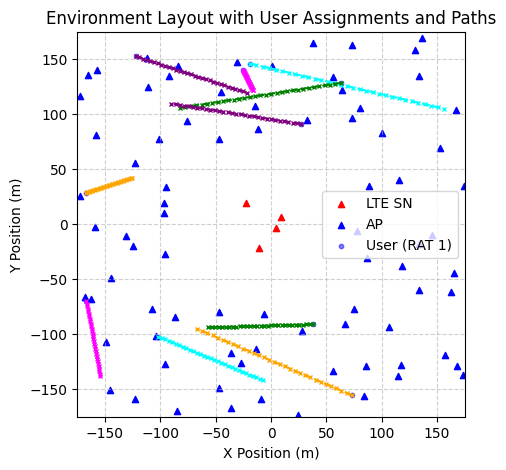

In [3]:
# Parameters for the Multi-RAT Network
user_area_width = 100
ltesn_area_width = 50
n_aps = 81
n_users = 10
n_steps = 30
cqi_dataset = pd.read_csv("cqi_distance.csv")
rssi_dataset = pd.read_csv("rssi_distance.csv")

rat_env = Multi_RAT_Network(user_area_width, ltesn_area_width, n_users, n_aps, cqi_dataset, rssi_dataset, n_steps, plot=True)

In [4]:
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim= rat_env.n_stations, lat_dims=512, layers=1)
action_network.load_state_dict(torch.load("Action_Net.pt"))
rewards,actions = evaluate_action_network(rat_env, action_network, n_episodes = 150)


C:\Users\alvar\AppData\Local\Temp\ipykernel_26212\2626173528.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  action_network.load_state_dict(torch.load("Action_Net.pt"))


In [5]:
APs_chosen = [value.item() for action in actions for value in action if value.item() > 3]
counted_aps = Counter(APs_chosen)
LTEs_chosen = [value.item() for action in actions for value in action if value.item() <= 3]
counted_ltes = Counter(LTEs_chosen)
average_LTE_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() <= 3 for value in action)])
average_AP_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() > 3 for value in action)])
all_rewards = torch.cat(rewards).numpy()
total_sn_chosen =  len(APs_chosen) + len(LTEs_chosen)
disconnections = np.sum(all_rewards < 0)

print(f"TEST RESULTS with {n_users} users in 150 episodes ({total_sn_chosen} stations chosen)")
print("-----------------------------------------")
print(f"{len(counted_aps)} APs chosen {len(APs_chosen)} times ({100 * len(APs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%) | {len(counted_ltes)} LTEs chosen {len(LTEs_chosen)} times ({100 * len(LTEs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%)")
print(f"User disconnected {disconnections} times ({(disconnections / total_sn_chosen):.5f} %)")
print(f"Average reward in LTEs: {average_LTE_reward:.3f} --> {average_LTE_reward * 600:.3f} Mb/s")
print(f"Average reward in APs: {average_AP_reward:.3f} --> {average_AP_reward * 600:.3f} Mb/s")
print("-----------------------------------------")
print(f"LTEs chosen :", counted_ltes)
print(f"APs chosen :", counted_aps)


TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
-----------------------------------------
15 APs chosen 7170 times (15.93%) | 4 LTEs chosen 37830 times (84.07%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.132 --> 79.206 Mb/s
Average reward in APs: 0.134 --> 80.339 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 12750, 3: 10530, 1: 7800, 2: 6750})
APs chosen : Counter({51: 630, 14: 570, 35: 570, 33: 570, 18: 570, 55: 570, 62: 540, 42: 540, 37: 510, 8: 450, 58: 390, 60: 390, 71: 360, 41: 360, 39: 150})


Let's tweak tau:

Let's see with 5*1e-2: we have more variability and slightly more APs are choosen but also twice the error rate, maybe when it works better this can be tuned but for now with 1e-2 works pretty nice, what if smaller though?
let's try 5e-1, with this again we reduce the error but also the variabilty.


 Let's leave it like this and play with gamma.For tweaking gamma you can try 0.97 and 0.95, right now is at 0.99

With 0.95 a bit more Aps selected but some erros, let's leave it with 0.97


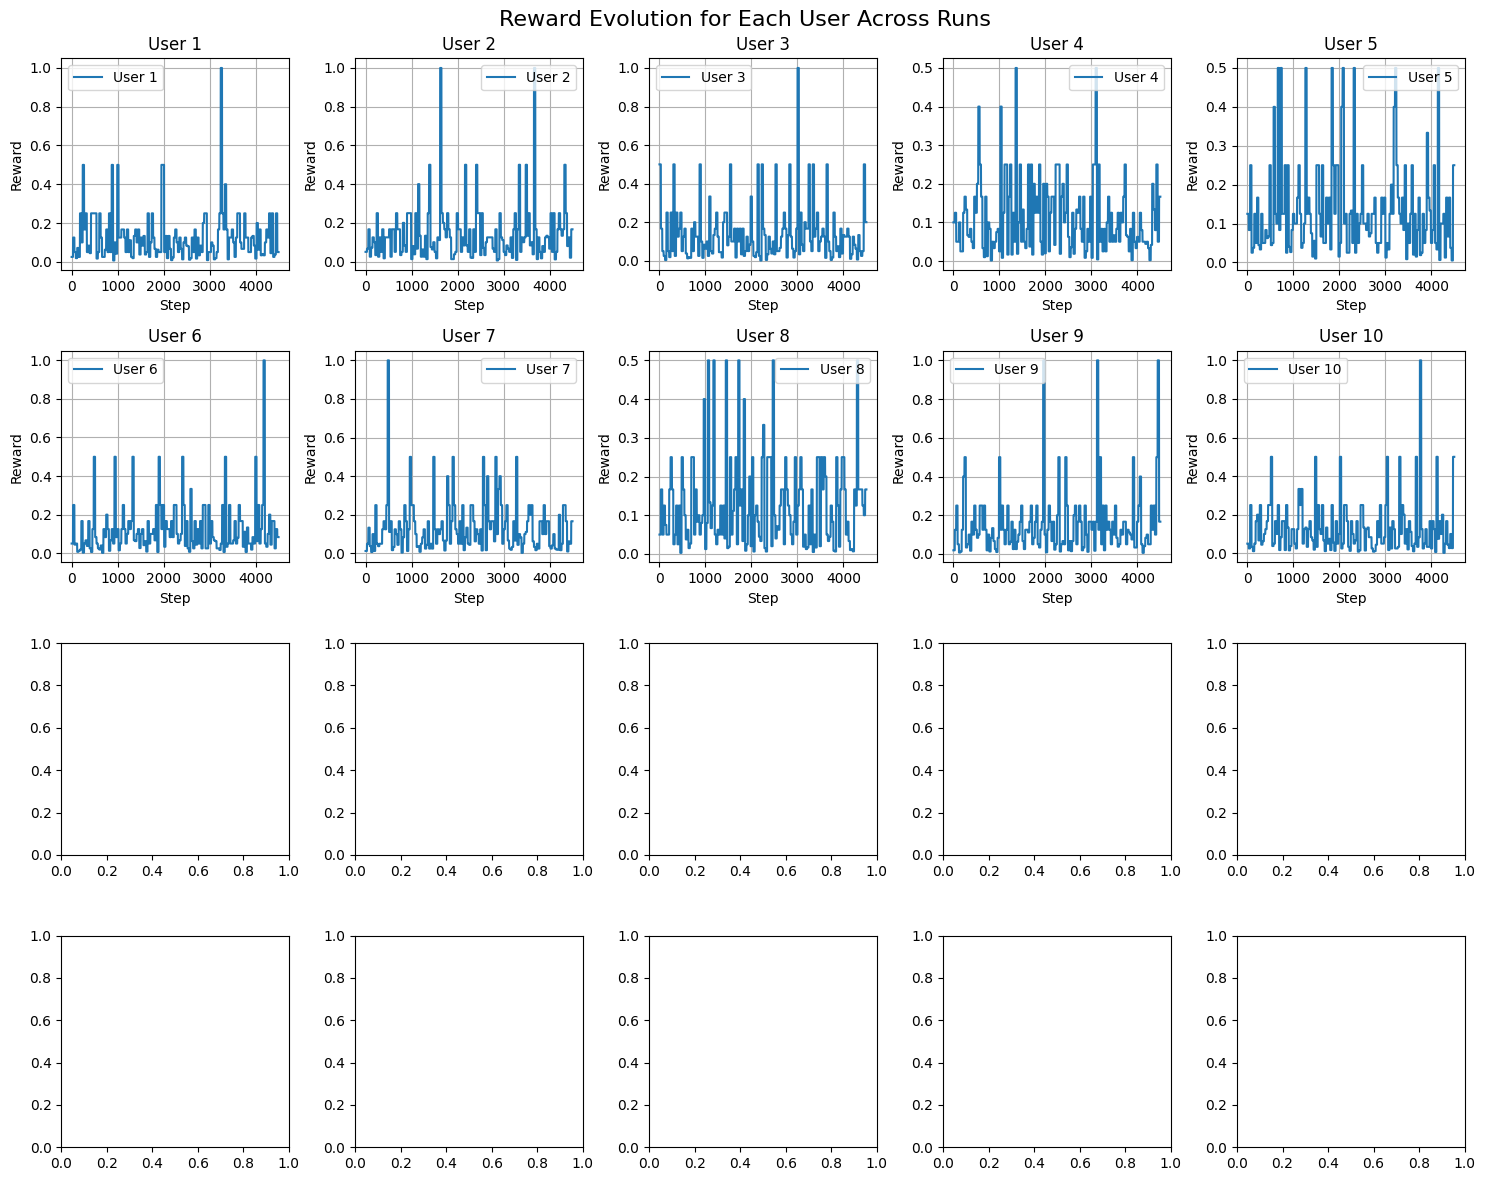

In [13]:
plot_reward(rewards)

Plot average_throughput per user and fairness

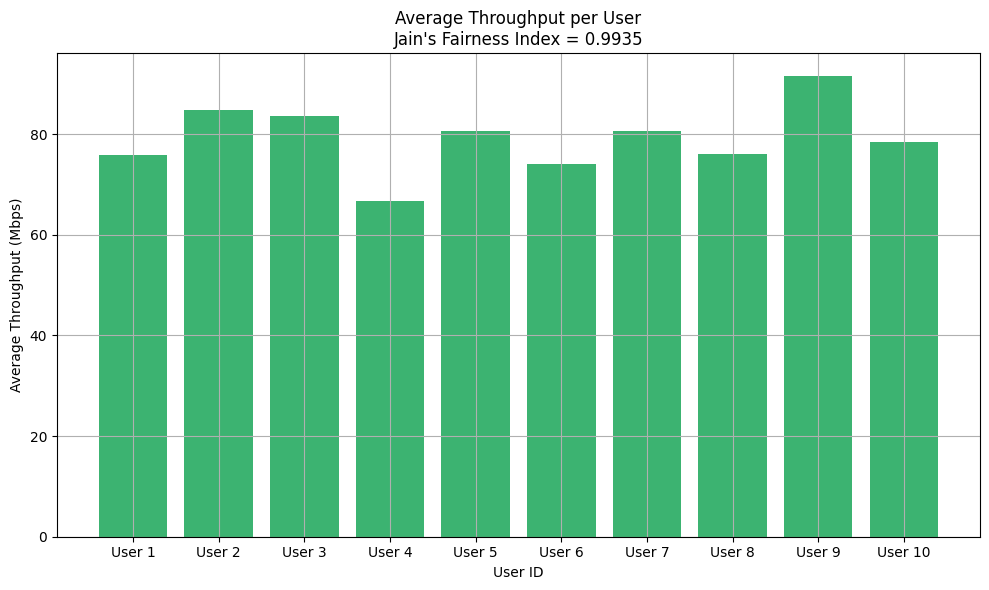

In [14]:
throughput_buffer = [
    [reward * rat_env.max_thr for reward in rewards]
    for rewards in rewards
]

# Step 3: Compute average throughput per user
n_users = len(throughput_buffer[0])
avg_throughput_per_user = [
    np.mean([throughput_buffer[episode][user] for episode in range(len(throughput_buffer))])
    for user in range(n_users)
]

# Step 4: Compute Jain's fairness index
numerator = (sum(avg_throughput_per_user)) ** 2
denominator = n_users * sum(x ** 2 for x in avg_throughput_per_user)
jain_index = numerator / denominator if denominator != 0 else 0

# Step 5: Plot average throughput per user
plt.figure(figsize=(10, 6))
plt.bar(range(n_users), avg_throughput_per_user, color='mediumseagreen')
plt.xlabel('User ID')
plt.xticks(ticks=range(n_users), labels=[f'User {i+1}' for i in range(n_users)])
plt.ylabel('Average Throughput (Mbps)')
plt.title(f'Average Throughput per User\nJain\'s Fairness Index = {jain_index:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

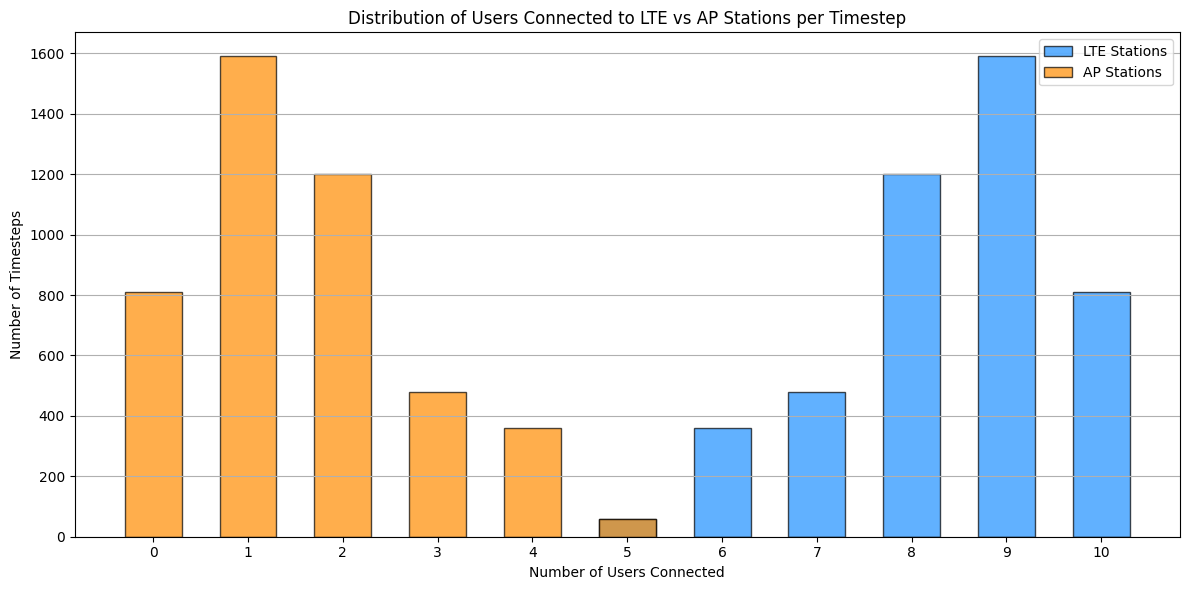

In [21]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

n_users = rat_env.n_users  # number of users

# Count users connected to LTE/AP per timestep
lte_counts_per_timestep = [sum(1 for a in action if a.item() <= 3) for action in actions]
ap_counts_per_timestep = [sum(1 for a in action if a.item() > 3) for action in actions]

# Count frequency of each number of users connected
lte_freq = Counter(lte_counts_per_timestep)
ap_freq = Counter(ap_counts_per_timestep)

# Prepare data for bar plot
x = np.arange(n_users + 1)  # from 0 to n_users

lte_values = [lte_freq.get(i, 0) for i in x]
ap_values = [ap_freq.get(i, 0) for i in x]

width = 0.6  # bar width

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x, lte_values, width, label='LTE Stations', color='dodgerblue', alpha=0.7, edgecolor='black')
ax.bar(x, ap_values, width, label='AP Stations', color='darkorange', alpha=0.7, edgecolor='black')

# Labeling
ax.set_xticks(x)
ax.set_xlabel('Number of Users Connected')
ax.set_ylabel('Number of Timesteps')
ax.set_title('Distribution of Users Connected to LTE vs AP Stations per Timestep')
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()


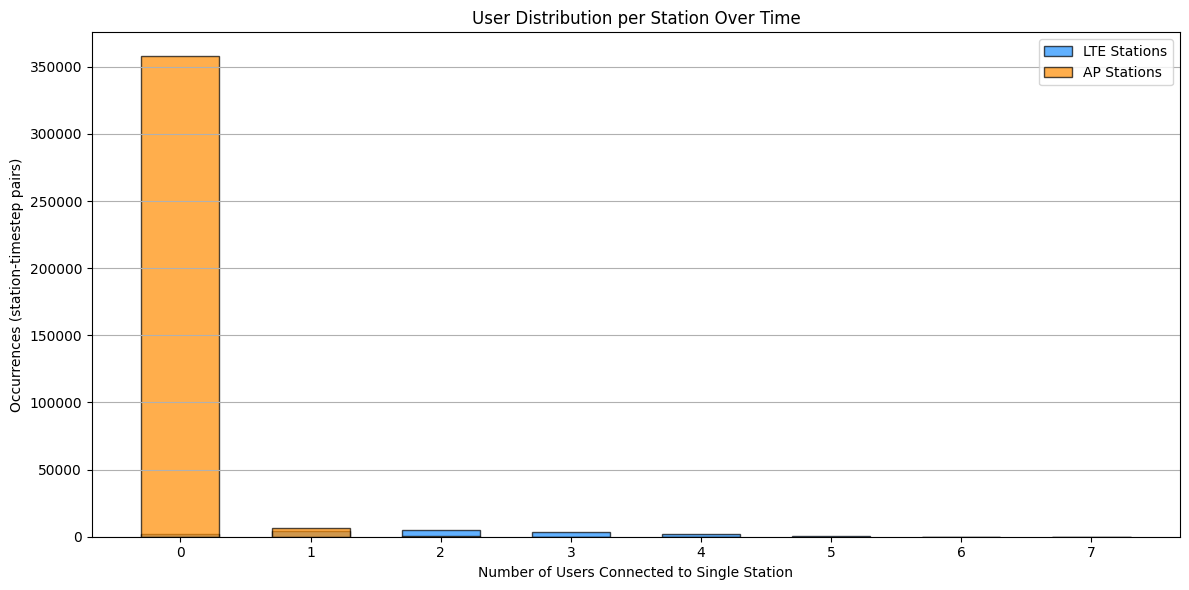

In [24]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Lists to hold counts of users connected to each station per timestep
lte_lists = []
ap_lists = []

lte_station_ids = list(range(4))  # IDs 0 to 3 LTE stations
ap_station_ids = list(range(4, rat_env.n_stations))  # IDs >3 AP stations

for action in actions:
    station_counts = Counter(a.item() for a in action)
    for st_id in lte_station_ids:
        lte_lists.append(station_counts.get(st_id, 0))
    for st_id in ap_station_ids:
        ap_lists.append(station_counts.get(st_id, 0))

# Frequency counts for plotting
lte_freq = Counter(lte_lists)
ap_freq = Counter(ap_lists)

max_count = max(max(lte_freq.keys(), default=0), max(ap_freq.keys(), default=0))
x = np.arange(max_count + 1)

lte_values = [lte_freq.get(i, 0) for i in x]
ap_values = [ap_freq.get(i, 0) for i in x]

width = 0.6
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, lte_values, width, label='LTE Stations', alpha=0.7, color='dodgerblue', edgecolor='black')
ax.bar(x, ap_values, width, label='AP Stations', alpha=0.7, color='darkorange', edgecolor='black')

ax.set_xticks(x)
ax.set_xlabel('Number of Users Connected to Single Station')
ax.set_ylabel('Occurrences (station-timestep pairs)')
ax.set_title('User Distribution per Station Over Time')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

n_users = rat_env.n_users  # total users

# Station IDs by RAT type
lte_station_ids = list(range(rat_env.n_ltesn))  # e.g. 0 to 3
ap_station_ids = list(range(rat_env.n_ltesn, rat_env.n_stations))

lte_percentages = []
ap_percentages = []

for action in actions:
    # Count users per station this timestep
    station_counts = Counter(a.item() for a in action)

    # Compute percentage of users connected to each LTE station at this timestep
    for st_id in lte_station_ids:
        count = station_counts.get(st_id, 0)
        percent = (count / n_users) * 100
        lte_percentages.append(percent)

    # Compute percentage of users connected to each AP station at this timestep
    for st_id in ap_station_ids:
        count = station_counts.get(st_id, 0)
        percent = (count / n_users) * 100
        ap_percentages.append(percent)

# Count frequency of each percentage rounded to 1 decimal (to group nicely)
def freq_from_percentages(percent_list):
    rounded = [round(p, 1) for p in percent_list if p > 0]  # exclude zeros
    return Counter(rounded)

lte_freq = freq_from_percentages(lte_percentages)
ap_freq = freq_from_percentages(ap_percentages)

# Prepare sorted x and y for plotting
lte_x = sorted(lte_freq.keys())
lte_y = [lte_freq[k] for k in lte_x]

ap_x = sorted(ap_freq.keys())
ap_y = [ap_freq[k] for k in ap_x]

# Plot side-by-side bar charts with percentages on x-axis and counts on y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax1.bar(lte_x, lte_y, width=0.8, color='dodgerblue', edgecolor='black', alpha=0.7)
ax1.set_title('LTE Stations')
ax1.set_xlabel('Percentage of Users Connected (%)')
ax1.set_ylabel('Occurrences (station-timestep pairs)')
ax1.set_xticks(lte_x)
ax1.grid(axis='y')

ax2.bar(ap_x, ap_y, width=0.8, color='darkorange', edgecolor='black', alpha=0.7)
ax2.set_title('AP Stations')
ax2.set_xlabel('Percentage of Users Connected (%)')
ax2.set_xticks(ap_x)
ax2.grid(axis='y')

plt.suptitle('Distribution of Percentage of Users Connected per Station Over Time\n(LTE vs AP Stations, excluding zero %)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


AttributeError: 'Multi_RAT_Network' object has no attribute 'n_ltestations'

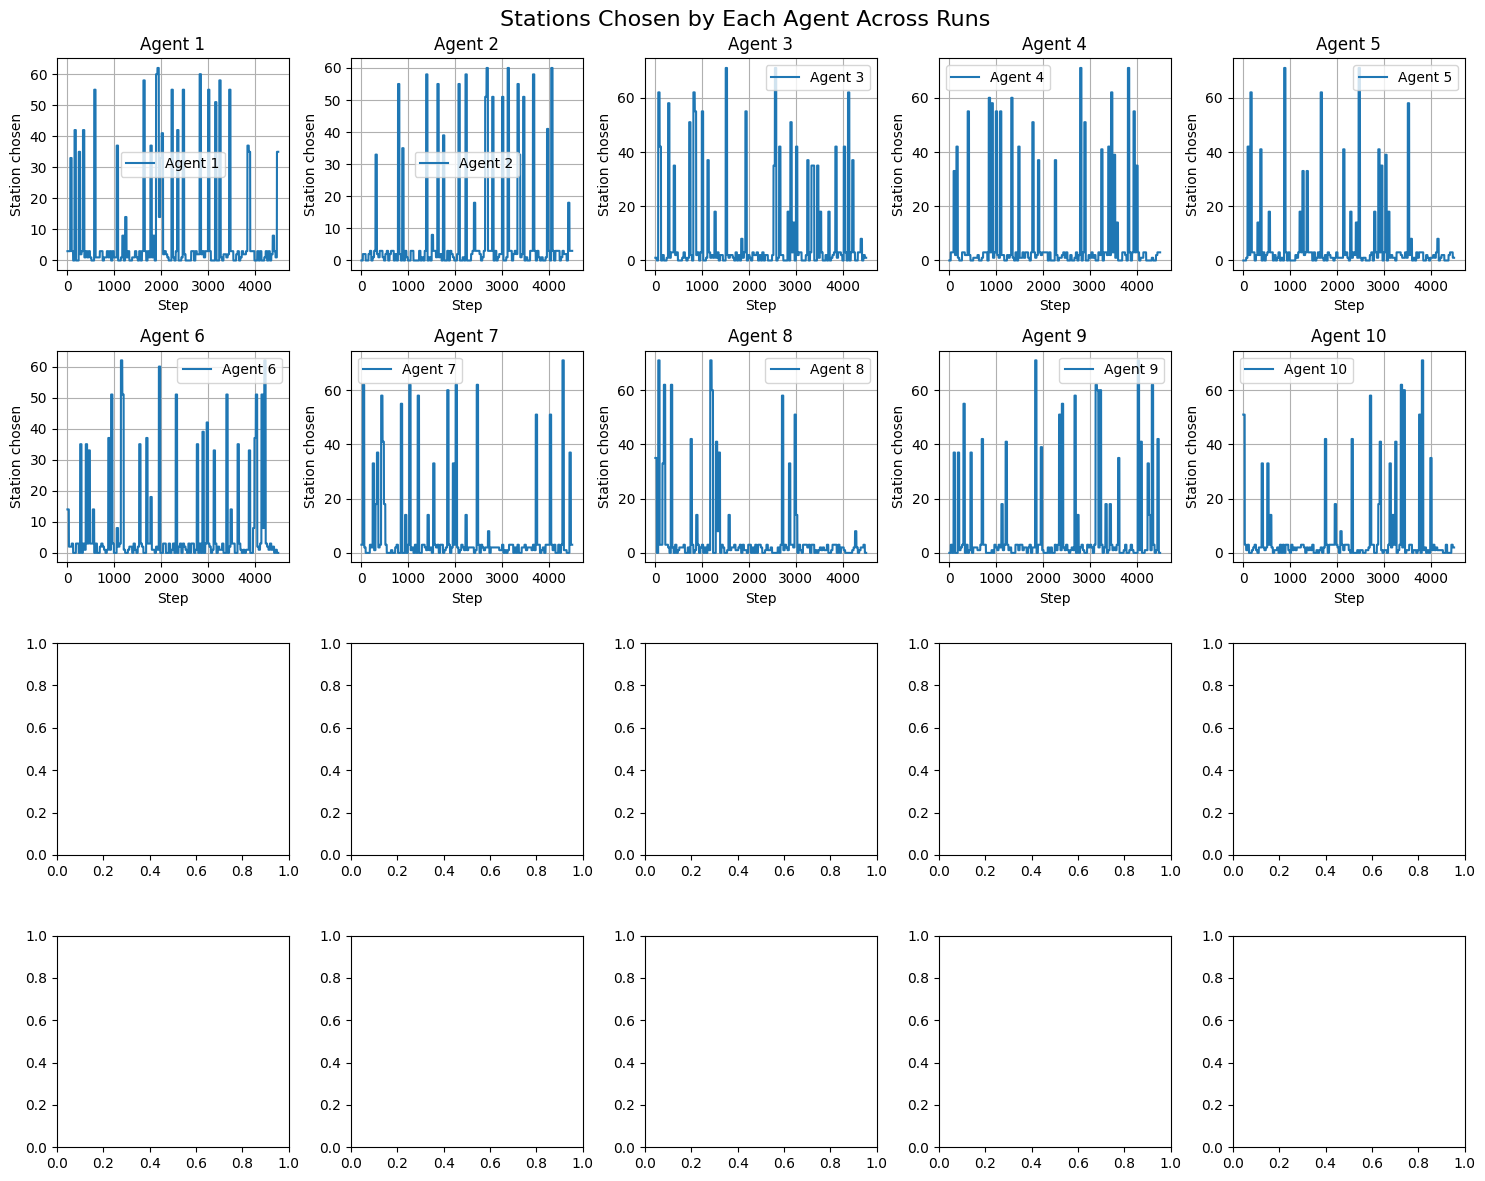

In [8]:
plot_actions(actions)